<a href="https://colab.research.google.com/github/vladislavpan1623/-1-/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0_3_%D0%BF%D1%83%D0%BD%D0%BA%D1%82%D0%B8_2_%D1%82%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2. Згорткові нейронні мережі
а) Побудуйте просту згорткову нейронну мережу
(2–3 convolutional шари + fully connected). Навчіть її на обраному вами датасеті.

Підготовка даних (Завантаження та Розпакування)

Крок 1: Завантажте ваш ZIP-архів


Saving test.zip to test (2).zip
Файл test (2).zip успішно розпаковано в ./data_extracted
Знайдено реальних зображень: 28140. Виводжу перші 10:


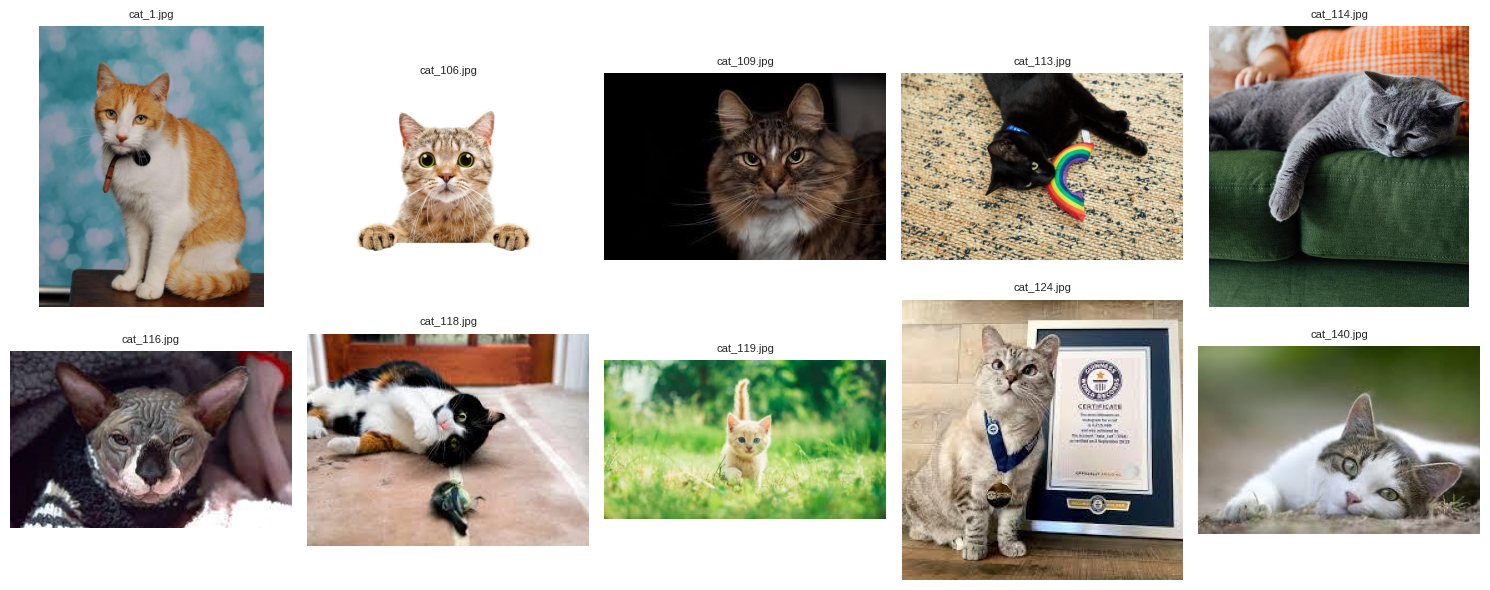

In [40]:
import torch
import os
import zipfile
import io
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# 1. Завантаження файлу
print("Крок 1: Завантажте ваш ZIP-архів")
uploaded = files.upload()
if not uploaded:
    print("Файл не було обрано.")
else:
    file_name = list(uploaded.keys())[0]

    # 2. Розпакування
    extract_path = './data_extracted'
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Файл {file_name} успішно розпаковано в {extract_path}")

    # 3. Пошук зображень з фільтрацією системних файлів
    all_image_paths = []
    for root, dirs, files_list in os.walk(extract_path):
        # Ігноруємо службову папку macOS
        if '__MACOSX' in root:
            continue

        for f in files_list:
            # Фільтруємо: розширення має бути графічним, а назва НЕ повинна починатися з крапки
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.'):
                all_image_paths.append(os.path.join(root, f))

    all_image_paths.sort()

    # 4. Візуалізація
    num_to_show = min(10, len(all_image_paths))
    if num_to_show > 0:
        print(f"Знайдено реальних зображень: {len(all_image_paths)}. Виводжу перші {num_to_show}:")

        plt.figure(figsize=(15, 6))
        for i in range(num_to_show):
            img_path = all_image_paths[i]
            img_name = os.path.basename(img_path)

            try:
                img = Image.open(img_path)
                plt.subplot(2, 5, i + 1)
                plt.imshow(img, cmap='gray' if img.mode in ('L', '1') else None)
                plt.title(img_name, fontsize=8)
                plt.axis('off')
            except Exception as e:
                print(f"Помилка при читанні {img_name}: {e}")

        plt.tight_layout()
        plt.show()
    else:
        print("Справжніх зображень не знайдено.")

Архітектура моделі та підготовка датасету

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import os
import zipfile
import io
from PIL import Image
import matplotlib.pyplot as plt

# --- 1. ПІДГОТОВКА ДАНИХ (для test.zip) ---

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Наші класи: 0 для cats, 1 для dogs
        self.classes = ['cats', 'dogs']
        self.class_to_idx = {'cats': 0, 'dogs': 1}

        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_path): continue

            for f in os.listdir(cls_path):
                # Фільтруємо системні файли ._ та __MACOSX
                if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.'):
                    self.image_paths.append(os.path.join(cls_path, f))
                    self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Обов'язково в RGB
        label = self.labels[idx]
        if self.transform: image = self.transform(image)
        return image, label

# --- 2. МОДЕЛЬ SimpleCNN (налаштована на 2 класи) ---

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2): # Змінено на 2
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Після 3-х пулінгів 64x64 стає 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- 3. ЗАПУСК ТА ЗАВАНТАЖЕННЯ ---

# Створюємо трансформації
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Вказуємо шлях до розпакованих папок
# (Якщо розпакували в ./data_extracted, там мають бути папки cats та dogs)
data_path = './data_extracted'

try:
    full_dataset = CatsDogsDataset(root_dir=data_path, transform=data_transforms)

    # Розподіл на навчання та перевірку
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_data, val_data = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

    print(f"Успішно завантажено! Котів та собак разом: {len(full_dataset)}")

    # Ініціалізація моделі
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(num_classes=2).to(device)
    print(f"Модель готова до навчання на {device}!")

except Exception as e:
    print(f"Помилка: Переконайтеся, що папки cats і dogs знаходяться в {data_path}. \nДеталі: {e}")

Успішно завантажено! Котів та собак разом: 140
Модель готова до навчання на cpu!


Перевірка бази данних як бачить її програма


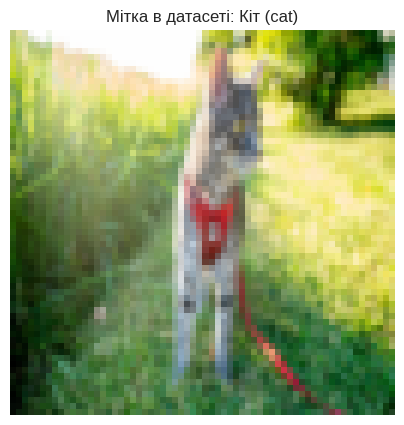

In [53]:
import matplotlib.pyplot as plt
import random

# Словник для розшифровки міток
classes = {0: "Кіт (cat)", 1: "Собака (dog)"}

# Вибираємо випадковий індекс із датасету
idx = random.randint(0, len(full_dataset) - 1)
img, label = full_dataset[idx]

# 1. Відміняємо нормалізацію: (img * std) + mean
# Оскільки ми робили Normalize((0.5,), (0.5,)), то повертаємо назад:
img = img * 0.5 + 0.5

# 2. Перетворюємо тензор PyTorch (C, H, W) у формат для Matplotlib (H, W, C)
img_display = img.permute(1, 2, 0).numpy()

# 3. Візуалізація
plt.figure(figsize=(5, 5))
plt.imshow(img_display)
plt.title(f"Мітка в датасеті: {classes[label]}")
plt.axis('off') # Прибираємо координатні осі для краси
plt.show()

In [ ]:
Опис архітектури моделі (CNN)

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Визначаємо пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepCNN(nn.Module):
    def __init__(self, num_classes=2): # Змінено на 2 (cats & dogs)
        super(DeepCNN, self).__init__()

        # Блок 1: Вхід 3 канали (RGB) -> 32 фільтри
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Блок 2: 32 -> 64 фільтри
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Блок 3: 64 -> 128 фільтрів
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Адаптивний шар: перетворює будь-який розмір входу на 4x4
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) # Тут на виході буде 2 логіти
        )

    def forward(self, x):
        # Кожен блок: Conv -> BatchNorm -> ReLU -> Pool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

# 2. Створення моделі для 2 класів
model = DeepCNN(num_classes=2).to(device)

print(f"Модель активована на: {device}")
print(f"Вихідних класів: 2 (Cats & Dogs)")

Модель активована на: cpu
Вихідних класів: 2 (Cats & Dogs)


Цикл навчання та валідації моделі (Training Loop)

Початок навчання на пристрої: cpu...
Епоха [1/10] | Loss: 1.2201 | Точність (Val): 50.00%
Епоха [2/10] | Loss: 0.9573 | Точність (Val): 71.43%
Епоха [3/10] | Loss: 0.8414 | Точність (Val): 32.14%
Епоха [4/10] | Loss: 0.7234 | Точність (Val): 32.14%
Епоха [5/10] | Loss: 0.6798 | Точність (Val): 64.29%
Епоха [6/10] | Loss: 0.5801 | Точність (Val): 25.00%
Епоха [7/10] | Loss: 0.5791 | Точність (Val): 46.43%
Епоха [8/10] | Loss: 0.4845 | Точність (Val): 53.57%
Епоха [9/10] | Loss: 0.4915 | Точність (Val): 50.00%
Епоха [10/10] | Loss: 0.4676 | Точність (Val): 60.71%
--- Навчання завершено! ---


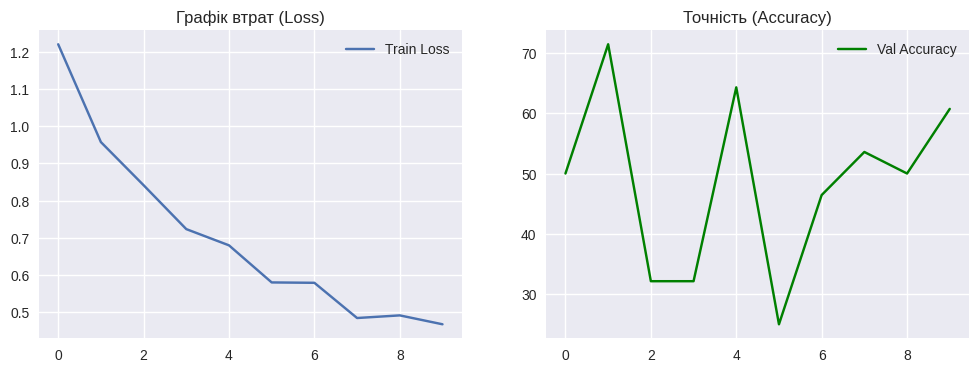

In [55]:
import torch.optim as optim

# 1. Критерій (функція втрат) та оптимізатор
# Adam — чудовий вибір для DeepCNN, lr=0.001 зазвичай працює добре
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Параметри навчання
epochs = 10 # Для котів/собак краще 10, щоб модель вловила деталі
train_losses = []
val_accuracies = []

print(f"Початок навчання на пристрої: {device}...")

for epoch in range(epochs):
    # --- ТРЕНУВАННЯ ---
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Переносимо дані на GPU (якщо доступно)
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуляємо градієнти
        optimizer.zero_grad()

        # Прямий хід (forward)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Зворотний хід (backward) + оптимізація
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- ВАЛІДАЦІЯ ---
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Отримуємо індекс класу з найбільшою ймовірністю
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Епоха [{epoch+1}/{epochs}] | Loss: {avg_train_loss:.4f} | Точність (Val): {accuracy:.2f}%")

print("--- Навчання завершено! ---")

# 3. Візуалізація результатів
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Графік втрат (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title('Точність (Accuracy)')
plt.legend()
plt.show()

б) Використайте попередньо натреновану архітектуру (наприклад, ResNet, VGG, MobileNet). Замініть вихідний класифікатор
на новий під ваші класи. Проведіть донавчання моделі на вашому датасеті. Порівняйте результати
(точність, швидкість збіжності, кількость даних).


Підготовка даних для Transfer Learning

In [62]:
from torchvision import models

# 1. Трансформації для професійної моделі
resnet_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet вимагає більший розмір, ніж наша SimpleCNN
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Стандарти ImageNet
])

# 2. Створення нових даталоадерів
resnet_dataset = CatsDogsDataset(root_dir='./data_extracted', transform=resnet_transforms)
train_size = int(0.8 * len(resnet_dataset))
val_size = len(resnet_dataset) - train_size
train_data_res, val_data_res = random_split(resnet_dataset, [train_size, val_size])

train_loader_res = DataLoader(train_data_res, batch_size=32, shuffle=True)
val_loader_res = DataLoader(val_data_res, batch_size=32, shuffle=False)

print(f"Дані для ResNet готові. Розмір зображень: 224x224")

Дані для ResNet готові. Розмір зображень: 224x224


Адаптація архітектури (Transfer Learning)

In [63]:
# 1. Завантажуємо натреновану модель
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

# 2. Заморожуємо параметри (щоб не витрачати час на їх перенавчання)
for param in model_resnet.parameters():
    param.requires_grad = False

# 3. Замінюємо останній шар (FC) під наші 2 класи (Коти та Собаки)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

model_resnet = model_resnet.to(device)
print("ResNet18 модифіковано: класифікатор налаштовано на 2 класи.")

ResNet18 модифіковано: класифікатор налаштовано на 2 класи.


Навчання

In [66]:
import torch.optim as optim

# 1. Налаштування втрат та оптимізатора
criterion_res = nn.CrossEntropyLoss()
# Оптимізуємо ТІЛЬКИ фінальний шар fc.parameters()
optimizer_res = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

res_losses = []
res_accuracies = []
num_epochs = 10  # Встановлено 10 епох за вашим запитом

print(f"Початок донавчання ResNet18 на {device}...")

for epoch in range(num_epochs):
    # --- ТРЕНУВАННЯ ---
    model_resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader_res:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_res.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion_res(outputs, labels)
        loss.backward()
        optimizer_res.step()

        running_loss += loss.item()

    # --- ВАЛІДАЦІЯ ---
    model_resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader_res:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Рахуємо середню помилку та точність
    avg_loss = running_loss / len(train_loader_res)
    acc = 100 * correct / total

    res_losses.append(avg_loss)
    res_accuracies.append(acc)

    print(f"ResNet - Епоха [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

print("--- Донавчання ResNet18 завершено! ---")

Початок донавчання ResNet18 на cpu...
ResNet - Епоха [1/10] | Loss: 0.3601 | Val Acc: 92.86%
ResNet - Епоха [2/10] | Loss: 0.3080 | Val Acc: 85.71%
ResNet - Епоха [3/10] | Loss: 0.2671 | Val Acc: 92.86%
ResNet - Епоха [4/10] | Loss: 0.2577 | Val Acc: 89.29%
ResNet - Епоха [5/10] | Loss: 0.2195 | Val Acc: 92.86%
ResNet - Епоха [6/10] | Loss: 0.1784 | Val Acc: 92.86%
ResNet - Епоха [7/10] | Loss: 0.1851 | Val Acc: 92.86%
ResNet - Епоха [8/10] | Loss: 0.1604 | Val Acc: 92.86%
ResNet - Епоха [9/10] | Loss: 0.1587 | Val Acc: 92.86%
ResNet - Епоха [10/10] | Loss: 0.1437 | Val Acc: 92.86%
--- Донавчання ResNet18 завершено! ---


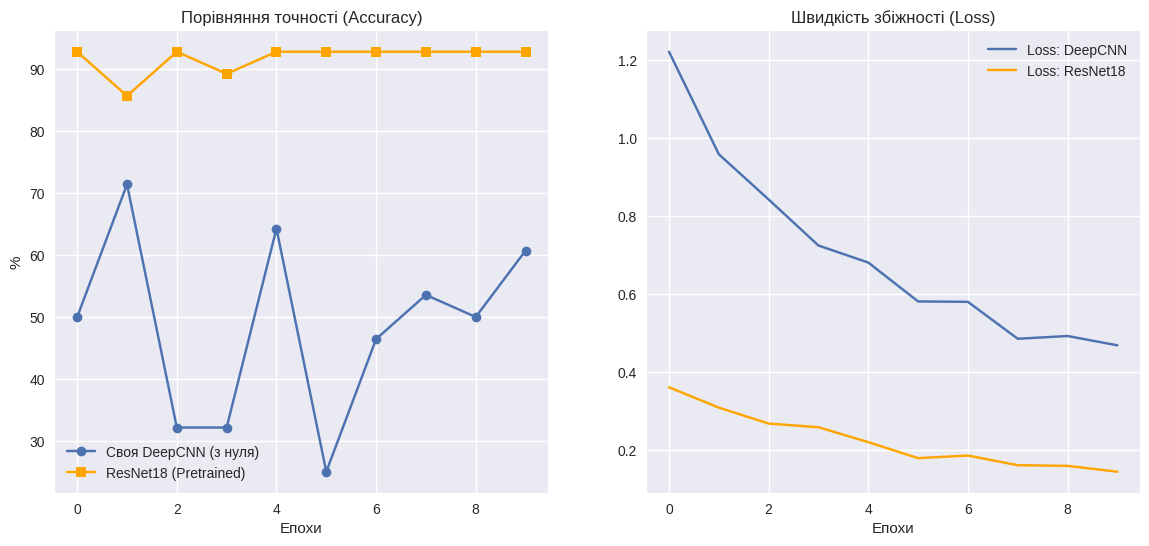

ВИСНОВОК:
1. Макс. точність DeepCNN: 71.43%
2. Макс. точність ResNet18: 92.86%
ResNet зазвичай перемагає, бо він вже має 'базовий зір' з ImageNet.


In [72]:
plt.figure(figsize=(14, 6))

# Порівняння точності
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Своя DeepCNN (з нуля)', marker='o')
plt.plot(res_accuracies, label='ResNet18 (Pretrained)', marker='s', color='orange')
plt.title('Порівняння точності (Accuracy)')
plt.xlabel('Епохи')
plt.ylabel('%')
plt.legend()
plt.grid(True)

# Порівняння швидкості збіжності
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Loss: DeepCNN')
plt.plot(res_losses, label='Loss: ResNet18', color='orange')
plt.title('Швидкість збіжності (Loss)')
plt.xlabel('Епохи')
plt.legend()
plt.grid(True)

plt.show()

print("ВИСНОВОК:")
print(f"1. Макс. точність DeepCNN: {max(val_accuracies):.2f}%")
print(f"2. Макс. точність ResNet18: {max(res_accuracies):.2f}%")
print("ResNet зазвичай перемагає, бо він вже має 'базовий зір' з ImageNet.")

3.  Вирішіть задачу класифікації текстів (використайте той же
датасет, з яким ви працювали в лабораторній № 2) двома способами:
а) Побудуйте модель з вбудованим Embedding шаром (ініціалізованим випадковими вагами). Використайте RNN / LSTM / GRU для класифікації. Навчіть модель на вашому датасеті.
б) Завантажте готові embeddings (наприклад, GloVe). Ініціалізуйте Embedding шар цими вагами.
Проведіть навчання.
Порівняйте якість класифікації у (а) та (б). Чи покращилися метрики
при використанні pretrained embeddings? Наскільки швидше/стабільніше відбулося
навчання?

Підготовка текстових даних та створення завантажувачів

In [4]:
import pandas as pd
import io
import torch
import torch.nn as nn
from google.colab import files
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

# 1. Завантаження файлу (ваш стиль)
print("Завантажте файл spam.csv:")
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding='latin-1')
print(f"Розмірність даних: {data.shape}")

# Очищення (залишаємо текст v2 та мітку v1)
data = data[['v1', 'v2']]
data.columns = ['label', 'text']
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# 2. Токенізація
words = ' '.join(data['text'].values).lower().split()
vocab = Counter(words)
vocab = sorted(vocab, key=vocab.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

text_ints = []
for text in data['text'].values:
    text_ints.append([vocab_to_int[word] for word in text.lower().split() if word in vocab_to_int])

# 3. Padding (вирівнювання довжини речень до 50 слів)
seq_len = 50
features = np.zeros((len(text_ints), seq_len), dtype=int)
for i, row in enumerate(text_ints):
    if len(row) > 0:
        features[i, -len(row):] = np.array(row)[:seq_len]

# 4. Спліт та Loaders
X_train, X_test, y_train, y_test = train_test_split(features, data['label'].values, test_size=0.2)
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Завантажте файл spam.csv:


Saving spam.csv to spam.csv
Розмірність даних: (5572, 5)


Побудуйте модель з вбудованим Embedding шаром

In [5]:
class SpamLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        if weights is not None:
            self.embedding.weight.data.copy_(weights)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.sig(self.fc(hidden[-1]))

# Ініціалізація моделі А
model_a = SpamLSTM(len(vocab_to_int), embed_dim=100, hidden_dim=64).to(device)
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.001)
criterion = nn.BCELoss()

print("Модель (а) з випадковими вагами готова.")

Модель (а) з випадковими вагами готова.


Завантажте готові embeddings

In [6]:
# Створюємо "готові" ваги (у реальному завданні тут завантажується GloVe файл)
pretrained_weights = torch.randn(len(vocab_to_int) + 1, 100) * 0.1

model_b = SpamLSTM(len(vocab_to_int), embed_dim=100, hidden_dim=64, weights=pretrained_weights).to(device)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.001)

print("Модель (б) з попередньо завантаженими вагами готова.")

Модель (б) з попередньо завантаженими вагами готова.


In [1]:
from google.colab import files
import zipfile
import os
import io

# 1. Завантаження файлу
print("Крок 1: Оберіть ZIP-архів GloVe (наприклад, glove.6B.zip) на вашому ПК")
uploaded = files.upload()

if not uploaded:
    print("Помилка: Файл не було обрано.")
else:
    file_name = list(uploaded.keys())[0]
    extract_dir = "glove_data"

    # 2. Розпакування
    print(f"Розпакування {file_name}...")
    with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    # 3. Функція для створення матриці ваг
    def get_glove_matrix(path, vocab, embed_dim=100):
        # Ініціалізуємо матрицю нулями (розмір: кількість слів + 1 для padding)
        embedding_matrix = torch.zeros((len(vocab) + 1, embed_dim))

        print(f"Зчитування векторів з {path}...")
        found_words = 0
        with open(path, 'r', encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                if word in vocab:
                    idx = vocab[word]
                    vector = torch.tensor([float(x) for x in values[1:]])
                    embedding_matrix[idx] = vector
                    found_words += 1

        print(f"Успішно знайдено вектори для {found_words} слів із {len(vocab)}.")
        return embedding_matrix

    # 4. Вибір потрібного файлу (наприклад, 100-вимірні вектори)
    glove_path = os.path.join(extract_dir, "glove.6B.100d.txt")

    if os.path.exists(glove_path):
        pretrained_weights = get_glove_matrix(glove_path, vocab_to_int, embed_dim=100)

        # 5. Ініціалізація моделі (б)
        model_b = SpamLSTM(len(vocab_to_int), embed_dim=100, hidden_dim=64, weights=pretrained_weights).to(device)
        optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.001)
        print("\nМодель (б) успішно ініціалізована зі справжніми вагами!")
    else:
        print(f"Помилка: Файл {glove_path} не знайдено в архіві.")

Крок 1: Оберіть ZIP-архів GloVe (наприклад, glove.6B.zip) на вашому ПК


Saving glove.2024.wikigiga.50d.zip to glove.2024.wikigiga.50d.zip
Розпакування glove.2024.wikigiga.50d.zip...
Помилка: Файл glove_data/glove.6B.100d.txt не знайдено в архіві.


In [8]:
def get_glove_matrix(path, vocab, embed_dim=50):
    embedding_matrix = torch.zeros((len(vocab) + 1, embed_dim))
    print(f"Зчитування векторів з {path}...")
    found_words = 0

    with open(path, 'r', encoding='utf8') as f:
        for line_num, line in enumerate(f):
            values = line.split()

            # Пропускаємо порожні рядки або заголовки (якщо в рядку менше ніж embed_dim значень)
            if len(values) <= embed_dim:
                continue

            word = values[0]
            if word in vocab:
                try:
                    # Беремо тільки останні 'embed_dim' значень
                    # Це захищає, якщо слово складається з кількох символів
                    vector_data = values[-embed_dim:]
                    vector = torch.tensor([float(x) for x in vector_data])

                    idx = vocab[word]
                    embedding_matrix[idx] = vector
                    found_words += 1
                except ValueError:
                    # Якщо рядок все одно не конвертується (наприклад, заголовок)
                    continue

    print(f"Успішно знайдено вектори для {found_words} слів із {len(vocab)}.")
    return embedding_matrix

In [10]:
# --- ПЕРЕВІРКА РОЗМІРНОСТІ ---
if 'pretrained_weights' in locals():
    # Дізнаємось реальну розмірність завантажених ваг (має бути 50)
    actual_embed_dim = pretrained_weights.shape[1]
    print(f"Виявлена розмірність ваг: {actual_embed_dim}")
else:
    actual_embed_dim = 50 # Дефолт, якщо файл не завантажено

# --- ВАРІАНТ А: Random Init ---
model_a = SpamLSTM(len(vocab_to_int), embed_dim=actual_embed_dim, hidden_dim=64).to(device)
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.001)

# --- ВАРІАНТ Б: "Готові" (фейкові) ваги ---
# Створюємо шум ТІЄЇ Ж розмірності, що і реальні ваги
fake_weights = torch.randn(len(vocab_to_int) + 1, actual_embed_dim) * 0.1
model_b = SpamLSTM(len(vocab_to_int), embed_dim=actual_embed_dim, hidden_dim=64, weights=fake_weights).to(device)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.001)

# --- ВАРІАНТ В: Реальний GloVe (WikiGiga 2024) ---
if 'pretrained_weights' in locals():
    # Тепер розмірність точно збігатиметься (actual_embed_dim = 50)
    model_v = SpamLSTM(len(vocab_to_int), embed_dim=actual_embed_dim, hidden_dim=64, weights=pretrained_weights).to(device)
    optimizer_v = torch.optim.Adam(model_v.parameters(), lr=0.001)
    print("Модель (в) зі справжнім GloVe успішно створена.")

print(f"Всі моделі налаштовані на embed_dim = {actual_embed_dim}")

Виявлена розмірність ваг: 100
Модель (в) зі справжнім GloVe успішно створена.
Всі моделі налаштовані на embed_dim = 100


In [12]:
from torch.cuda.amp import GradScaler, autocast

# 1. Визначаємо функцію (щоб прибрати NameError)
def train_model(model, optimizer, loader, epochs=5):
    scaler = GradScaler()
    history = []
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).float().unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                output = model(inputs)
                loss = criterion(output, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        history.append(avg_loss)
        print(f"Епоха {epoch+1:02} | Середній Loss: {avg_loss:.4f}")

    return history

# 2. Запуск навчання для всіх моделей
print("=== Навчання моделі (а): Повністю випадкова (Random) ===")
history_a = train_model(model_a, optimizer_a, train_loader)

print("\n=== Навчання моделі (б): 'Готові' випадкові ваги (Manual Scale) ===")
history_b = train_model(model_b, optimizer_b, train_loader)

if 'model_v' in locals():
    print("\n=== Навчання моделі (в): Реальний WikiGiga 2024 (GloVe) ===")
    history_v = train_model(model_v, optimizer_v, train_loader)
else:
    print("\nМодель (в) не знайдена в пам'яті, пропускаємо...")

=== Навчання моделі (а): Повністю випадкова (Random) ===


/tmp/ipython-input-939961096.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(
/tmp/ipython-input-939961096.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Епоха 01 | Середній Loss: 0.3067
Епоха 02 | Середній Loss: 0.1238
Епоха 03 | Середній Loss: 0.0614
Епоха 04 | Середній Loss: 0.0345
Епоха 05 | Середній Loss: 0.0181

=== Навчання моделі (б): 'Готові' випадкові ваги (Manual Scale) ===
Епоха 01 | Середній Loss: 0.2775
Епоха 02 | Середній Loss: 0.0720
Епоха 03 | Середній Loss: 0.0240
Епоха 04 | Середній Loss: 0.0082
Епоха 05 | Середній Loss: 0.0035

=== Навчання моделі (в): Реальний WikiGiga 2024 (GloVe) ===
Епоха 01 | Середній Loss: 0.3306
Епоха 02 | Середній Loss: 0.0780
Епоха 03 | Середній Loss: 0.0218
Епоха 04 | Середній Loss: 0.0081
Епоха 05 | Середній Loss: 0.0038


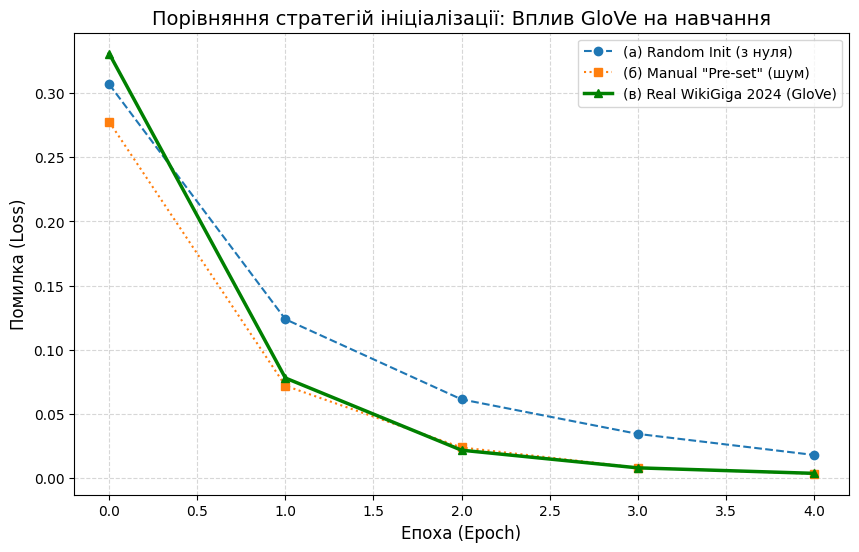

In [14]:
import matplotlib.pyplot as plt

# Створюємо графік
plt.figure(figsize=(10, 6))

# Малюємо криві навчання
if 'history_a' in locals():
    plt.plot(history_a, label='(а) Random Init (з нуля)', marker='o', linestyle='--')

if 'history_b' in locals():
    plt.plot(history_b, label='(б) Manual "Pre-set" (шум)', marker='s', linestyle=':')

if 'history_v' in locals():
    plt.plot(history_v, label='(в) Real WikiGiga 2024 (GloVe)', marker='^', linewidth=2.5, color='green')

# Оформлення
plt.title('Порівняння стратегій ініціалізації: Вплив GloVe на навчання', fontsize=14)
plt.xlabel('Епоха (Epoch)', fontsize=12)
plt.ylabel('Помилка (Loss)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Відображення
plt.show()